In [1]:
from xclib.data import data_utils
import pandas as pd
import numpy as np
from numpy import log2 as log
from collections import Counter, OrderedDict
from scipy.stats import mode
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from scipy.sparse import csc_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
'''Global Params'''
val_n_estimators = []
test_n_estimators = []

val_max_features = []
test_max_features = []

val_min_samples = []
test_min_samples = []

In [3]:
#TrainData = data_utils.read_sparse_file('data/train_x.txt', force_header = True, dtype="float32")
'''Load Data'''
TrainData = pd.read_csv("data/train_x.csv", header = None)
TrainLabels = pd.read_csv("data/train_y.csv", header = None)
TrainData['labels'] = TrainLabels
print(Counter(TrainData.labels))

ValData = pd.read_csv("data/valid_x.csv", header = None)
ValLabels = pd.read_csv("data/valid_y.csv", header = None)
ValData['labels'] = ValLabels
print(Counter(ValData.labels))

TestData = pd.read_csv("data/test_x.csv", header = None)
TestLabels = pd.read_csv("data/test_y.csv", header = None)
TestData['labels'] = TestLabels
print(Counter(TestData.labels))

Counter({1.0: 34153, 0.0: 30560})
Counter({1.0: 11270, 0.0: 10302})
Counter({1.0: 11420, 0.0: 10151})


In [4]:
#train_x = csc_matrix(TrainData.to_numpy()[:,:-1])
#Train_X = train_x.todense()
'''Convert Data to numpy'''
Train_X = TrainData.to_numpy()[:,:-1]
Train_Y = TrainData.to_numpy()[:,-1]

Val_X = ValData.to_numpy()[:,:-1]
Val_Y = ValData.to_numpy()[:,-1]

Test_X = TestData.to_numpy()[:,:-1]
Test_Y = TestData.to_numpy()[:,-1]

In [5]:
'''create list of params'''
n_estimator_list = [i for i in range(50,451,100)]
max_features_list = [round(0.1 * i, 1) for i in range(1,10,2)]
min_samples_split_list = [i for i in range(2,11,2)]
print(n_estimator_list, max_features_list,  min_samples_split_list)

[50, 150, 250, 350, 450] [0.1, 0.3, 0.5, 0.7, 0.9] [2, 4, 6, 8, 10]


In [7]:
def hyperParameterTuning():
    '''Function for hyperparameter tuning using random forest classifier using GridSearchCV'''
    
    now = datetime.now()

    current_time = now.strftime("%H:%M:%S")
    print("Start Time =", current_time)
    t0 = time.time()
    params_grid = [{'n_estimators': n_estimator_list,
                   'max_features': max_features_list,
                   'min_samples_split': min_samples_split_list,
                   'oob_score': [True]}]
    
    rfc = RandomForestClassifier()
    
    gridSearch = GridSearchCV(rfc, params_grid, cv = 5, scoring = 'accuracy', n_jobs = 6, verbose = 10, refit = True)
    print(gridSearch)
    gridSearchResults = gridSearch.fit(Train_X, Train_Y.ravel())
    t1 = time.time()
    print("Hyper Parameter Tuning Time = {}Mins".format(round((t1-t0)/60,2)))
    return gridSearchResults

def accuracyForOptimalParams(estimator):
    '''Calculate accuracies using  best estimator from hyperparameter tuning'''
    
    print("Training Begins..!")
    t0 = time.time()
    rfc = estimator
    
    rfc.fit(Train_X, Train_Y.ravel())
    
    t1 = time.time()
    print("Time to train = {}Sec".format(round((t1-t0),2)))
    print("\n Prediction Begins..!")
    TrainPredict = rfc.predict(Train_X)
    TrainAccuracy = 100 * accuracy_score(Train_Y, TrainPredict)
    
    ValPredict = rfc.predict(Val_X)
    ValAccuracy = 100 * accuracy_score(Val_Y, ValPredict)
    
    TestPredict = rfc.predict(Test_X)
    TestAccuracy = 100 * accuracy_score(Test_Y, TestPredict)
    
    print("\nTrain Accuracy = {}%".format(round(TrainAccuracy,2)))
    print("\nOut-of-Bag Accuracy = {}%".format(round(100*rfc.oob_score_,2)))
    print("\nVal Accuracy = {}%".format(round(ValAccuracy,2)))
    print("\nTest Accuracy = {}%".format(round(TestAccuracy,2)))
    return TrainAccuracy, 100*rfc.oob_score_, ValAccuracy, TestAccuracy

def paramSensitivityAnalysis(bestParams):
    '''Parameter sensitivity analysis. vary one param keeping other two to their optimal value'''
    print("\n$$For n_estimators List keeping others constant")
    for i in range(len(n_estimator_list)):
        print("\nn_estimators =", n_estimator_list[i])
        rfc1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=bestParams['max_features'], max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=bestParams['min_samples_split'],
                       min_weight_fraction_leaf=0.0, n_estimators=n_estimator_list[i],
                       n_jobs=6, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)
        
        rfc1.fit(Train_X, Train_Y.ravel())
        
        ValPredict = rfc1.predict(Val_X)
        ValAccuracy = 100 * accuracy_score(Val_Y, ValPredict)
        print("Validation Accuracy = {}%".format(round(ValAccuracy, 2)))
        val_n_estimators.append(ValAccuracy)

        TestPredict = rfc1.predict(Test_X)
        TestAccuracy = 100 * accuracy_score(Test_Y, TestPredict)
        print("Test Accuracy = {}%".format(round(TestAccuracy, 2)))
        test_n_estimators.append(TestAccuracy)
        

    print("\n$$For max_features List keeping others constant")
    for i in range(len(max_features_list)):
        print("\nmax_features =", max_features_list[i])
        rfc2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=max_features_list[i], max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=bestParams['min_samples_split'],
                       min_weight_fraction_leaf=0.0, n_estimators=bestParams['n_estimators'],
                       n_jobs=6, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)
        
        rfc2.fit(Train_X, Train_Y.ravel())
        
        ValPredict = rfc2.predict(Val_X)
        ValAccuracy = 100 * accuracy_score(Val_Y, ValPredict)
        print("Validation Accuracy = {}%".format(round(ValAccuracy, 2)))
        val_max_features.append(ValAccuracy)

        TestPredict = rfc2.predict(Test_X)
        TestAccuracy = 100 * accuracy_score(Test_Y, TestPredict)
        print("Test Accuracy = {}%".format(round(TestAccuracy, 2)))
        test_max_features.append(TestAccuracy)
            
    print("\n$$For min_samples_split List keeping others constant")
    for i in range(len(min_samples_split_list)):
        print("\nmin_samples_split =", min_samples_split_list[i])
        rfc3 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=bestParams['max_features'], max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=min_samples_split_list[i],
                       min_weight_fraction_leaf=0.0, n_estimators=bestParams['n_estimators'],
                       n_jobs=6, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)
        
        rfc3.fit(Train_X, Train_Y.ravel())
        
        ValPredict = rfc3.predict(Val_X)
        ValAccuracy = 100 * accuracy_score(Val_Y, ValPredict)
        print("Validation Accuracy = {}%".format(round(ValAccuracy, 2)))
        val_min_samples.append(ValAccuracy)

        TestPredict = rfc3.predict(Test_X)
        TestAccuracy = 100 * accuracy_score(Test_Y, TestPredict)
        print("Test Accuracy = {}%".format(round(TestAccuracy, 2)))
        test_min_samples.append(TestAccuracy)
        
    return

def plotParamSensitivityAnalysis(bestParams):
    '''Plot results for sensitivity analysis'''

    fig0 = plt.figure(0)
    plt.plot(n_estimator_list, val_n_estimators[-5:], c="tab:green", marker="o", label="Validation Accuracy")
    plt.plot(n_estimator_list, test_n_estimators[-5:], c="tab:orange", marker="x", label="Test Accuracy")
    plt.xlabel("n_estimators")
    plt.ylabel("accuracy")
    plt.title("n_estimators vs accuracy for\n max_features = {} & min_samples_split = {}"
              .format(bestParams['max_features'], bestParams['min_samples_split']))
    plt.legend()
    plt.show()
    fig0.savefig("plots/q_c_n_estimators.png", dpi= 300, pad_inches=0.1, format="png")
    
    fig1 = plt.figure(1)
    plt.plot(max_features_list, val_max_features, c="tab:green", marker="o", label="Validation Accuracy")
    plt.plot(max_features_list, test_max_features, c="tab:orange", marker="x", label="Test Accuracy")
    plt.xlabel("max_features")
    plt.ylabel("accuracy")
    plt.title("max_features vs accuracy for\n n_estimators = {} & min_samples_split = {}"
              .format(bestParams['n_estimators'], bestParams['min_samples_split']))
    plt.legend()
    plt.show()
    fig1.savefig("plots/q_c_max_features.png", dpi= 300, pad_inches=0.1, format="png")
    
    fig2 = plt.figure(2)
    plt.plot(min_samples_split_list, val_min_samples, c="tab:green", marker="o", label="Validation Accuracy")
    plt.plot(min_samples_split_list, test_min_samples, c="tab:orange", marker="x", label="Test Accuracy")
    plt.xlabel("min_samples_split")
    plt.ylabel("accuracy")
    plt.title("min_samples_split vs accuracy for\n max_features = {} & n_estimators = {}"
              .format(bestParams['max_features'], bestParams['n_estimators']))
    plt.legend()
    plt.show()
    fig2.savefig("plots/q_c_min_samples_split.png", dpi= 300, pad_inches=0.1, format="png")
    
    return
        

    
        

In [8]:
print("@@@@@@@@@@*********Q1_C*********@@@@@@@@@@")
GridSearchResults = hyperParameterTuning()

@@@@@@@@@@*********Q1_C*********@@@@@@@@@@
Start Time = 23:37:25
GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   40.4s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed: 27.9min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 32.6min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed: 40.1min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed: 45.8min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed: 52.8min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed: 60.3min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed: 70.3min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 88.9min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed: 109.5min
[Parallel

Hyper Parameter Tuning Time = 977.47Mins


In [9]:
print("\n$$$$$$------BEST_ESTIMATOR------$$$$$$")
bestEstimator = GridSearchResults.best_estimator_
print(bestEstimator)


$$$$$$------BEST_ESTIMATOR------$$$$$$
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)


In [10]:
print("\n$$$$$$------BEST_PARAMS------$$$$$$")
bestGridParams = GridSearchResults.best_params_
print(bestGridParams)


$$$$$$------BEST_PARAMS------$$$$$$
{'max_features': 0.1, 'min_samples_split': 10, 'n_estimators': 250, 'oob_score': True}


In [11]:
print("\n$$$$$$------Q1_C_Results------$$$$$$")
TrainA, OOBA, ValA, TestA = accuracyForOptimalParams(bestEstimator)


$$$$$$------Q1_C_Results------$$$$$$
Training Begins..!
Time to train = 109.85Sec

 Prediction Begins..!

Train Accuracy = 87.39%

Out-of-Bag Accuracy = 80.99%

Val Accuracy = 80.7%

Test Accuracy = 80.77%


In [12]:
print("\n@@@@@@@@@@*********Q1_D*********@@@@@@@@@@")
paramSensitivityAnalysis(bestGridParams)


@@@@@@@@@@*********Q1_D*********@@@@@@@@@@

$$For n_estimators List keeping others constant

n_estimators = 50
Validation Accuracy = 80.4%
Test Accuracy = 80.7%

n_estimators = 150
Validation Accuracy = 80.62%
Test Accuracy = 80.74%

n_estimators = 250
Validation Accuracy = 80.64%
Test Accuracy = 80.77%

n_estimators = 350
Validation Accuracy = 80.72%
Test Accuracy = 80.86%

n_estimators = 450
Validation Accuracy = 80.71%
Test Accuracy = 80.8%

$$For max_features List keeping others constant

max_features = 0.1
Validation Accuracy = 80.58%
Test Accuracy = 80.85%

max_features = 0.3
Validation Accuracy = 80.56%
Test Accuracy = 80.72%

max_features = 0.5
Validation Accuracy = 80.64%
Test Accuracy = 80.65%

max_features = 0.7
Validation Accuracy = 80.51%
Test Accuracy = 80.58%

max_features = 0.9
Validation Accuracy = 80.37%
Test Accuracy = 80.51%

$$For min_samples_split List keeping others constant

min_samples_split = 2
Validation Accuracy = 79.65%
Test Accuracy = 79.9%

min_samples_s

In [13]:
print("\n$$$$$$------Q1_D_Results------$$$$$$")
print(val_n_estimators[-5:])
print(test_n_estimators[-5:])

print(val_max_features)
print(test_max_features)

print(val_min_samples)
print(test_min_samples)


$$$$$$------Q1_D_Results------$$$$$$
[80.40051919154459, 80.61839421472278, 80.63693676988689, 80.71574262933431, 80.70647135175227]
[80.70094107829956, 80.73802790783922, 80.77047888368644, 80.86319595753558, 80.79829400584117]
[80.58130910439458, 80.56276654923047, 80.64157240867792, 80.50713888373818, 80.36806972000741]
[80.85392425015067, 80.71948449306939, 80.64531083399008, 80.57577302860321, 80.50623522321636]
[79.64954570739849, 79.99258297793436, 80.30317077693306, 80.474689412201, 80.59521602076765]
[79.90357424319689, 80.27444253859348, 80.57113717491076, 80.62676741922024, 80.88637522599787]


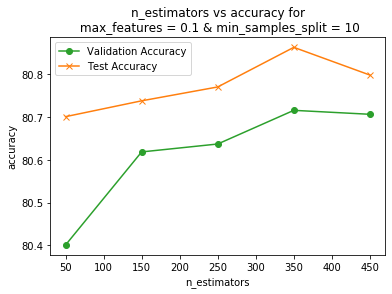

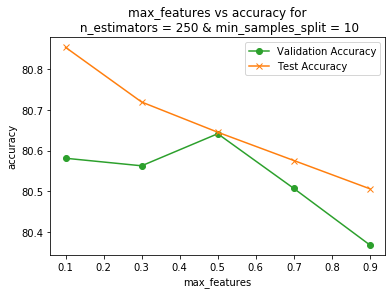

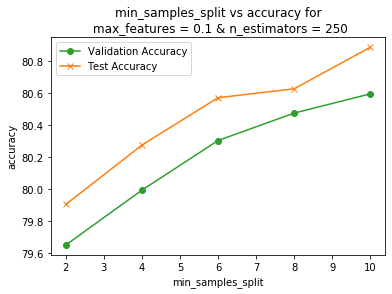

In [14]:
plotParamSensitivityAnalysis(bestGridParams)